In [ ]:
%pip install nilearn xarray seaborn tqdm pygal netcdf4 pynisher

In [3]:
%reload_ext autoreload
%autoreload 3

from src.acnets.pipeline import Parcellation, NetworkAggregator
from src.acnets.pipeline import ConnectivityExtractor, ConnectivityVectorizer

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, VarianceThreshold
from sklearn.model_selection import  GridSearchCV, StratifiedShuffleSplit, permutation_test_score
import pandas as pd
import numpy as np
import pygal as pg
import xarray as xr

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
def extract_network_connectivity(X=None,
          atlas='gordon2014_2mm',
          connectivity='correlation',
          aggregate_networks=True):

    p = Parcellation(atlas)
    n = NetworkAggregator(p.labels_)
    c = ConnectivityExtractor(connectivity)

    if aggregate_networks:
        conn = make_pipeline(p, n, c).fit_transform(X)
        nodes = n.networks_.to_list()
    else:
        conn = make_pipeline(p, c).fit_transform(X)
        nodes = p.labels_.index.to_list()


    conn = xr.DataArray(
        conn,
        coords={'subject': p.dataset_['subject'],
                'node': nodes},
        dims=['subject', 'node', 'node'],
        name='connectivity')

    if X is not None:
        conn = conn.sel(dict(subject=X.reshape(-1).tolist()))

    return conn


In [5]:


def plot_grid_search_results(grid, score_name='accuracy'):
    sns.set_style('ticks')
    sns.despine()

    results = grid.cv_results_
    n_splits = grid.cv.get_n_splits()

    param_names = []
    for param in results['param_connectivity__kw_args']:
        atlas = param['atlas'].replace('_','\_')
        connectivity = param['connectivity']
        feature = 'network' if param['aggregate_networks'] else 'region' 
        param_names.append(f'$\\bf{{{atlas}}}$\n{connectivity} ({feature})')

    cv_scores = []
    for i in range(n_splits):
        scores = results[f'split{i}_test_score']
        cv_scores.extend(list(zip(param_names, scores)))

    test_results  = pd.DataFrame(cv_scores, columns=['parcellation', score_name])
    test_results['mean_score'] = test_results.groupby('parcellation').transform(np.mean)
    test_results.sort_values('mean_score', ascending=False, inplace=True)
    # DEBUG print(test_results.groupby('parcellation').min())

    _, ax = plt.subplots(figsize=(len(param_names) * 1.1, 5))
    sns.lineplot(data=test_results.iloc[::-1], x='parcellation', y=score_name, lw=3, sort=False, ax=ax)
    sns.scatterplot(data=test_results.iloc[::-1], x='parcellation', y='mean_score', marker='o', s=100,ax=ax)
    ax.axhline(.5, linestyle='--', color='red')
    lgd = ax.legend(['average', '95% CI', '_average', 'chance'],
                    title_fontproperties={'weight':'bold', 'size':'x-large'},
                    prop={'size':'xx-large'},
                    title=f'{n_splits} $\\times$ 5-fold CV')
    ax.get_legend()._legend_box.align = 'left'
    ax.set_xlabel('')
    ax.set_ylabel('accuracy', fontsize='xx-large')
    plt.xticks(rotation=45, ha='right', fontsize='x-large', rotation_mode='anchor')
    plt.suptitle('$\\bf{SVM}$ classification accuracy (validation set)', fontsize='xx-large', y=.95)
    plt.grid(axis='y')

    # table = plt.table(cellText=[['s','s2','s3','s4','s5'],['s','s2','s','s','s']],
    #                   rowLabels=['atlas','connectivity'],
    #                   rowColours=['lightgreen','gray'],
    #                 #   colLabels=['1','2'],
    #                 colLoc=['center','center'],
    #                   loc='bottom')

    plt.show()

# plot_grid_search_results(grid)

In [6]:
pipe  = Pipeline([
    ('connectivity', FunctionTransformer(extract_network_connectivity)),
    ('vectorize', ConnectivityVectorizer()),
    # ('select', SelectFromModel(SVC(kernel='linear'))),
    # ('select', SelectFromModel(LinearSVC(C=5, max_iter=100000))),
    ('zv', VarianceThreshold(threshold=0)),
    # ('svm', SVC(kernel='linear', probability=True))
    ('svm', LinearSVC(C=.1, max_iter=100000))
    # ('rfc', RandomForestClassifier())
])


params = {
    'connectivity__kw_args': [
        
        # dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=False),
        # dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=False),
        # dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=False),

        dict(atlas='gordon2014_2mm', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='precision', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='gordon2014_2mm', connectivity='chatterjee', aggregate_networks=True),

        # dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=False),
        # dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=False),
        # dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=False),

        dict(atlas='dosenbach2010', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='precision', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='dosenbach2010', connectivity='chatterjee', aggregate_networks=True),

        # dict(atlas='difumo_64_2mm', connectivity='correlation', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='tangent', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='precision', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='partial correlation', aggregate_networks=True),
        # dict(atlas='difumo_64_2mm', connectivity='chatterjee', aggregate_networks=True)

    ],
    # 'select__estimator__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__C': [0.1, .3, .5, 1, 3, 5],
    # 'svm__kernel': ['linear', 'rbf'],
}

In [7]:
subjects = extract_network_connectivity().coords['subject'].values
y = np.array([s[:4] for s in subjects])
X = subjects.reshape(-1, 1)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[WARNING] [2022-03-17 00:16:20,438:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[CV] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[WARNING] [2022-03-17 00:17:23,051:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-03-17 00:17:24,559:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2022-03-17 00:17:26,444:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2022-03-17 00:17:27,545:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 3. Number of dummy models: 1
[WARNING] [2022-03-17 00:17:29,831:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 4. Number of dummy models: 1
[WARNING] [2022-03-17 00:17:31,882:Client-EnsembleBuilder] No models better than random - 

/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'gordon2014_2mm', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 1.0min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=  57.8s


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 2.3min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[WARNING] [2022-03-17 00:23:48,872:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 1. Number of dummy models: 1
[WARNING] [2022-03-17 00:23:51,325:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 2. Number of dummy models: 1
[WARNING] [2022-03-17 00:23:52,881:Client-EnsembleBuilder] No models better than random - using Dummy loss!Number of models besides current dummy model: 3. Number of dummy models: 1
[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=  53.8s


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time=  56.4s


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)


[CV] END connectivity__kw_args={'atlas': 'dosenbach2010', 'connectivity': 'correlation', 'aggregate_networks': True}; total time= 1.1min


/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.metafeatures = self.metafeatures.append(metafeatures)
/usr/local/lib/python3.8/dist-packages/autosklearn/metalearning/metalearning/meta_base.py:72: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.algorithm_runs[metric].append(runs)
/tmp/ipykernel_817/3740570630.py:29: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x7f99463729d0> has a label of '_average' which cannot be automatically added to the legend.
  lgd = ax.legend(['average', '95% CI', '_average', 'chance'],


<Figure size 432x288 with 0 Axes>

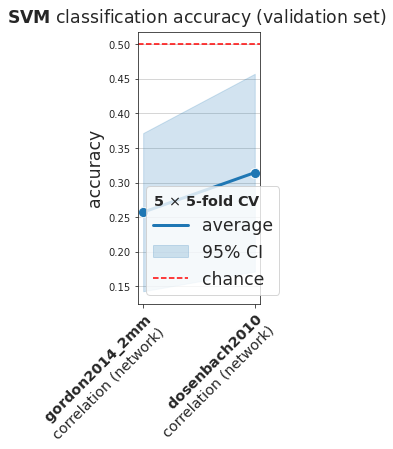

In [9]:
try:
    from autosklearn.classification import AutoSklearnClassifier

    subjects = extract_network_connectivity().coords['subject'].values
    y = np.array([s[:4] for s in subjects])
    X = subjects.reshape(-1, 1)

    train, test = StratifiedShuffleSplit(n_splits=1, test_size=0.2).split(X, y).__next__()

    # pipeline
    automl_pipe  = Pipeline([
    ('connectivity', FunctionTransformer(
        extract_network_connectivity,
        kw_args=dict(atlas='dosenbach2010',
                     connectivity='correlation',
                     aggregate_networks=True))),
    ('vectorize', ConnectivityVectorizer()),
    ('automl', AutoSklearnClassifier(time_left_for_this_task=60))
    ], verbose=0)

    # perform pipeline on all parcellations
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
    automl_grid = GridSearchCV(automl_pipe, params, verbose=3, cv=cv, scoring='accuracy')
    automl_grid.fit(X, y)
    plot_grid_search_results(automl_grid)

except Exception as e:
    print(e)